In [1]:
%run 0_3_configure_mlflow.ipynb

Experiment_id: 1
Artifact Location: file:///C:/Users/Piotrek/Documents/Inzynierka/csgo-analysis/mlruns/1
Tags: {}
Lifecycle_stage: active


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
import os
import shutil

from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, GRU, Dense, Masking, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

# Wczytanie danych

In [3]:
def select_feat():
    columns = [
        'seconds', 'ctAlivePlayers', 'ctEqVal', 'tAlivePlayers', 'tEqVal',
       'ct_armor', 't_armor', 'ct_hp', 't_hp', 'ct_hasHelmet', 't_hasHelmet', 'ct_DecoyGrenade',
       't_DecoyGrenade', 'ct_Flashbang', 't_Flashbang', 'ct_HEGrenade',
       't_HEGrenade', 'ct_SmokeGrenade', 't_SmokeGrenade', 'ct_fireGrenades',
       't_fireGrenades', 'ct_isBlinded', 't_isBlinded', 'ct_hasDefuse',
       't_hasBomb', 'ct_isDefusing', 't_isPlanting', 'ct_spottedPlayers',
       't_spottedPlayers', 'ct_grouppedPlayers',
       'ct_meanDist', 'ct_minDist', 't_meanDist','t_minDist',
       't_grouppedPlayers', 'ct_conquerMap', 't_conquerMap', 'ct_activeWeapon_Pistol',
       'ct_activeWeapon_EnhancedPistols', 'ct_activeWeapon_Deagle',
       'ct_activeWeapon_SMG', 'ct_activeWeapon_WeakAssaultRifle',
       'ct_activeWeapon_LunetRifle', 'ct_activeWeapon_SniperRifle',
       'ct_activeWeapon_AssaultRifle', 'ct_activeWeapon_Others',
       't_activeWeapon_Pistol', 't_activeWeapon_EnhancedPistols',
       't_activeWeapon_Deagle', 't_activeWeapon_SMG',
       't_activeWeapon_WeakAssaultRifle', 't_activeWeapon_LunetRifle',
       't_activeWeapon_SniperRifle', 't_activeWeapon_AssaultRifle',
       't_activeWeapon_Others', 'ct_mainWeapon_Pistol',
       'ct_mainWeapon_EnhancedPistols', 'ct_mainWeapon_Deagle',
       'ct_mainWeapon_SMG', 'ct_mainWeapon_WeakAssaultRifle',
       'ct_mainWeapon_LunetRifle', 'ct_mainWeapon_SniperRifle',
       'ct_mainWeapon_AssaultRifle', 't_mainWeapon_Pistol', 't_mainWeapon_EnhancedPistols',
       't_mainWeapon_Deagle', 't_mainWeapon_SMG',
       't_mainWeapon_WeakAssaultRifle', 't_mainWeapon_LunetRifle',
       't_mainWeapon_SniperRifle', 't_mainWeapon_AssaultRifle', 
       'ct_secondaryWeapon_Pistol','ct_secondaryWeapon_EnhancedPistols', 'ct_secondaryWeapon_Deagle',
       't_secondaryWeapon_Pistol', 't_secondaryWeapon_EnhancedPistols',
       't_secondaryWeapon_Deagle', 'ctMinDistToA',
       'ctMinDistToB', 'tMinDistToA', 'tMinDistToB', 'ctMeanDistToA',
       'ctMeanDistToB', 'tMeanDistToA', 'tMeanDistToB', 'ctMeanKills',
       'tMeanKills', 'tScore', 'ctScore', 'de_ancient', 
       'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke', 'de_overpass',
       'de_vertigo','bombsite_A', 'bombsite_B', 'bombsite_not_planted'
    ]
    return columns

In [4]:
df = pd.read_parquet('data/ESTA_states_prepared.parquet', columns=select_feat() + ['matchName', 'demoId', 'roundNum'])
df

,seconds,ctAlivePlayers,ctEqVal,tAlivePlayers,tEqVal,ct_armor,t_armor,ct_hp,t_hp,ct_hasHelmet,...,de_mirage,de_nuke,de_overpass,de_vertigo,bombsite_A,bombsite_B,bombsite_not_planted,matchName,demoId,roundNum
0,0.007874,5,4400,5,4250,400,300,500,500,0,...,0,1,0,0,0,0,1,heroic-vs-big-iem-katowice-2021,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
1,0.511811,5,4400,5,4250,400,300,500,500,0,...,0,1,0,0,0,0,1,heroic-vs-big-iem-katowice-2021,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
2,1.015748,5,4400,5,4250,400,300,500,500,0,...,0,1,0,0,0,0,1,heroic-vs-big-iem-katowice-2021,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
3,1.519685,5,4400,5,4250,400,300,500,500,0,...,0,1,0,0,0,0,1,heroic-vs-big-iem-katowice-2021,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
4,2.023622,5,4400,5,4250,400,300,500,500,0,...,0,1,0,0,0,0,1,heroic-vs-big-iem-katowice-2021,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7464293,81.464567,3,26800,1,24300,290,94,233,74,3,...,0,0,0,1,0,0,1,spirit-vs-copenhagen-flames-pgl-major-antwerp-...,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464294,81.968504,3,26800,1,24300,290,94,233,74,3,...,0,0,0,1,0,0,1,spirit-vs-copenhagen-flames-pgl-major-antwerp-...,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464295,82.472441,3,26800,1,24300,286,94,206,74,3,...,0,0,0,1,0,0,1,spirit-vs-copenhagen-flames-pgl-major-antwerp-...,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464296,82.976378,2,26800,1,24300,194,94,159,74,2,...,0,0,0,1,0,0,1,spirit-vs-copenhagen-flames-pgl-major-antwerp-...,ff910f54-0bed-4fdf-afa8-b481be09a788,26


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7464298 entries, 0 to 7464297
Columns: 102 entries, seconds to roundNum
dtypes: float64(17), int32(6), int64(67), object(2), uint8(10)
memory usage: 5.1+ GB


In [6]:
y = pd.read_parquet("data/ESTA_states_prepared.parquet", columns=["matchName", "winningSideCT"])

## All dataset

In [7]:
filtr = ~df.matchName.str.endswith("iem-katowice-2022")
df = df[filtr].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7137130 entries, 0 to 7137129
Columns: 102 entries, seconds to roundNum
dtypes: float64(17), int32(6), int64(67), object(2), uint8(10)
memory usage: 4.8+ GB


In [8]:
y = y[filtr].drop(['matchName'], axis='columns')
y = y.reset_index(drop=True)
y

,winningSideCT
0,0
1,0
2,0
3,0
4,0
...,...
7137125,1
7137126,1
7137127,1
7137128,1


In [9]:
groupped = df.groupby(['demoId'])
samples_indexes = groupped.indices
len(samples_indexes)

1494

In [10]:
maps = len(samples_indexes.keys())
np.random.seed(12)
train_ind = np.random.choice(maps, size=int(0.8*maps), replace=False)
train_indexes = np.array([])
valid_indexes = np.array([])
for i, key in enumerate(samples_indexes):
    if i in train_ind:
        train_indexes = np.concatenate((train_indexes, samples_indexes[key]))
    else:
        valid_indexes = np.concatenate((valid_indexes, samples_indexes[key]))

train_indexes.shape, valid_indexes.shape

((5709205,), (1427925,))

In [11]:
X = df.drop(['demoId', 'roundNum', 'matchName'], axis='columns')
y = y.squeeze()
X.shape, y.shape

((7137130, 99), (7137130,))

In [12]:
X_train, y_train = X.iloc[train_indexes], y.iloc[train_indexes]
X_val, y_val = X.iloc[valid_indexes], y.iloc[valid_indexes]
X_train.shape, X_val.shape

((5709205, 99), (1427925, 99))

In [13]:
X_test = pd.read_parquet("data/states_another_mod_test.parquet", columns=select_feat())
y_test = pd.read_parquet("data/states_another_mod_test.parquet", columns=["winningSideCT"])
y_test = y_test.squeeze()
X_test.shape

(620392, 99)

In [14]:
y_train.value_counts(normalize=True), y_val.value_counts(normalize=True), y_test.value_counts(normalize=True)

(1    0.518687
 0    0.481313
 Name: winningSideCT, dtype: float64,
 1    0.522383
 0    0.477617
 Name: winningSideCT, dtype: float64,
 1    0.5046
 0    0.4954
 Name: winningSideCT, dtype: float64)

In [15]:
cols = X_train.columns.tolist()
scaler = StandardScaler()
norm_train = scaler.fit_transform(X_train)
norm_valid = scaler.transform(X_val)
norm_test = scaler.transform(X_test)

In [16]:
os.makedirs("model_deep", exist_ok=True)

In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=30,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True,
)

model_checkpoint_callback = ModelCheckpoint(
    filepath="model_deep/multi_layer.tf",
    monitor='val_loss',
    mode='min',
    save_best_only=True)

logger = CSVLogger(
    "model_deep/perceptron_log.csv", separator=',', append=True
)

In [18]:
model = Sequential()
model.add(InputLayer(input_shape=(norm_train.shape[-1])))
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2'))

model.compile(optimizer="Adam", loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(), AUC()])
history = model.fit(x=norm_train,
                    y=y_train,
                    batch_size=2048,
                    epochs=1000,
                    validation_data=(norm_valid, y_val),
                    callbacks=[early_stopping, model_checkpoint_callback, logger])

Epoch 1/1000
2788/2788 [==============================] - 13s 4ms/step - loss: 0.5008 - binary_accuracy: 0.7609 - auc: 0.8597 - val_loss: 0.4686 - val_binary_accuracy: 0.7666 - val_auc: 0.8631
INFO:tensorflow:Assets written to: model_deep\multi_layer.tf\assets
Epoch 2/1000
2788/2788 [==============================] - 10s 4ms/step - loss: 0.4735 - binary_accuracy: 0.7610 - auc: 0.8601 - val_loss: 0.4686 - val_binary_accuracy: 0.7619 - val_auc: 0.8630
INFO:tensorflow:Assets written to: model_deep\multi_layer.tf\assets
Epoch 3/1000
2788/2788 [==============================] - 10s 4ms/step - loss: 0.4731 - binary_accuracy: 0.7611 - auc: 0.8601 - val_loss: 0.4674 - val_binary_accuracy: 0.7677 - val_auc: 0.8636
INFO:tensorflow:Assets written to: model_deep\multi_layer.tf\assets
Epoch 4/1000
2788/2788 [==============================] - 10s 4ms/step - loss: 0.4729 - binary_accuracy: 0.7610 - auc: 0.8601 - val_loss: 0.4687 - val_binary_accuracy: 0.7623 - val_auc: 0.8630
Epoch 5/1000
2788/2788 [

INFO:tensorflow:Assets written to: models/model.tf\assets


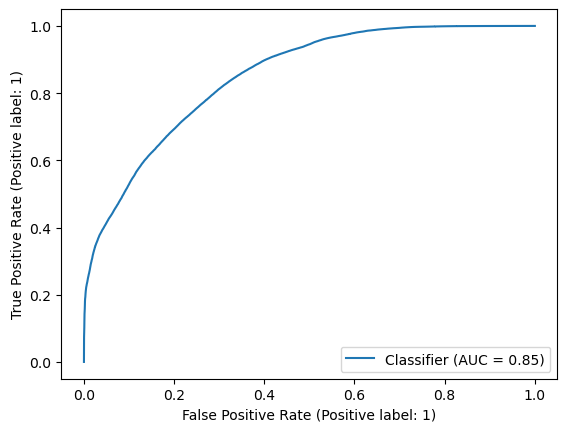

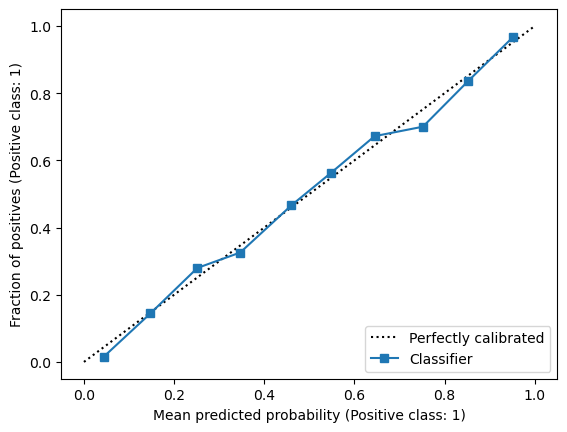

In [19]:
run_name = "Multi Layer Perceptron - ESTA"
additional_description = "Multi Layer Perceptron"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_param("X_train.shape", norm_train.shape)
        mlflow.log_param("X_test.shape", norm_test.shape)

        y_proba = model.predict(norm_test)
        y_true = y_test
        features_names = cols
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        if os.path.exists('artifacts'):
            shutil.rmtree('artifacts')
            os.makedirs('artifacts')
        
        if os.path.exists('models'):
            shutil.rmtree('models')
            os.makedirs('models')
            
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        model.save('models/model.tf')

        with open("models/scaler.pkl", "wb") as f:
            pickle.dump(scaler, f)
            
        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.png')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.png')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")

In [20]:
test_df = pd.read_parquet("data/states_another_mod_test.parquet", columns=select_feat() + ["filename"])
past = test_df['filename'].str.startswith("IEM-Katowice")
future = test_df['filename'].str.startswith("BLAST-Premier-Spring-Final-2022")
test_y = pd.read_parquet("data/states_another_mod_test.parquet", columns=["winningSideCT"])
test_y = test_y.squeeze()
test_df.shape

(620392, 100)

In [21]:
test_set = test_df.drop("filename", axis="columns")
test_set = scaler.fit_transform(test_set)
test_set.shape

(620392, 99)

In [22]:
results = []
y_true = test_y
y_pred = model.predict(test_set)
results = {
        "LogLoss (all)": log_loss(y_true, y_pred),
        "LogLoss (future)": log_loss(y_true[future], y_pred[future]),
        "LogLoss (past)": log_loss(y_true[past], y_pred[past]),
        "AUC-ROC (all)": roc_auc_score(y_true, y_pred),
        "AUC-ROC (future)": roc_auc_score(y_true[future], y_pred[future]),
        "AUC-ROC (past)": roc_auc_score(y_true[past], y_pred[past])
}
results

{'LogLoss (all)': 0.46876810875801295,
 'LogLoss (future)': 0.4699464495365301,
 'LogLoss (past)': 0.4676693784077154,
 'AUC-ROC (all)': 0.8495904555172672,
 'AUC-ROC (future)': 0.8515347801347402,
 'AUC-ROC (past)': 0.8470425557675663}